## Latent Space
We can now look at the trained samples in latent space. The latent space is a 2 dimensional representation of the wavesets ordered by similiarity. Each waveset is a point in the 2D space. We can think of a song as a series of jumps from waveset to waveset, i.e. a series of 2D coordinates. We want to save these series and train another network to create a new series.

In [1]:
from Variational_Autoencoder_alla_Valerio import VAE as Autoencoder
import numpy as np
import matplotlib.pyplot as plt
import librosa.display


First we load the trained autoencoder and the training data from our disk:

In [3]:
autoencoder = Autoencoder.load("VAE_2D_0.5_64")
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
This model was trained with 7420 wavesets and has a 2D latent space
Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_Input (InputLayer)  [(None, 256, 64, 1)]      0         
                                                                 
 Encoder (Functional)        (None, 2)                 355716    
                                                                 
 Decoder (Functional)        (None, 256, 64, 1)        308737    
                                                                 
Total params: 664,453
Trainable params: 663,621
Non-trainable params: 832
_________________________________________________________________
Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #   

In [11]:
subfolder = "0.5_64"

def load_data(subfolder):
    spectogram_data = np.load("data\\" + subfolder + "spectos.npy")
    song_labels = np.load("data\\" + subfolder + "song_labels.npy")
    position_labels = np.load("data\\" + subfolder + "position_labels.npy")
    print(spectogram_data.shape)
    
    return spectogram_data, position_labels, song_labels

x_train, y_train, y_train_alt = load_data(subfolder)

(7420, 256, 64, 1)


## Data in latent space
We can now plot our wavesets in the latent space. Each waveset is reduced to a point in the 2 dimensional space. The distance between the points of two wavesets corresponds to their similarity. The colors represent at which position in a song the waveset occured (first 10% of the song, second 10% of the song and so on).

In [7]:
latent_representation = autoencoder.encoder.predict(x_train)

D:\Daten\Studium\Semester_7\MusikInfo\MetaHuman\venv\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


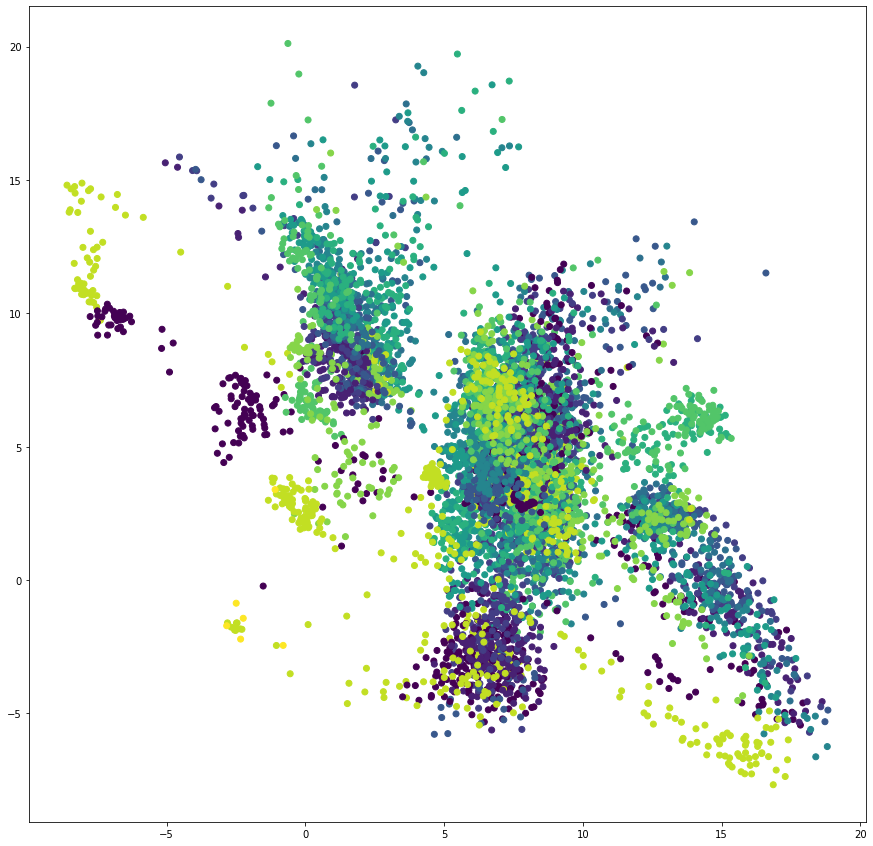

In [8]:
plt.figure(figsize=(15, 15))
plt.scatter(latent_representation[:, 0], latent_representation[:, 1], c=y_train)
plt.show()

## Generate Song Orders
A song is a series of wavesets. This series of wavesets corresponds to a list of coordinates in the latent space. It can be imagined as a movement - or more precisely a sequence of jumps - through the latent space. Later we want to use these sequences as training data for a second network. On their basis the second network will be able to produce new sequences. For this we need to store the series of coordinates for each song. We create a list of 2D arrays: first dimension is the song, and second dimension is the a tuple of coordinates.

In [12]:
num_of_ws_per_song = np.load("data\\" + subfolder + "WSnum.npy")

start_ws = 0
stop_ws = 0
song_orders = []

for i, num_of_ws in enumerate(num_of_ws_per_song):
    stop_ws += num_of_ws
    song_order = latent_representation[start_ws : stop_ws]
    song_order = np.reshape(song_order, (num_of_ws, 2))
    song_orders.append(song_order)
    start_ws += num_of_ws
    
song_orders = np.asarray(song_orders, dtype=object)

We save the new list of song_orders on disk for later use:

In [14]:
save_path = "data\\" + subfolder + "song_orders.npy"
np.save(save_path,song_orders)


## The latent space representation of one song
We can plot the latent representation of a song. The subsequent wavesets are connected by lines to visualize, that the sequence of wavesets corresponds to a path trough the latent space.

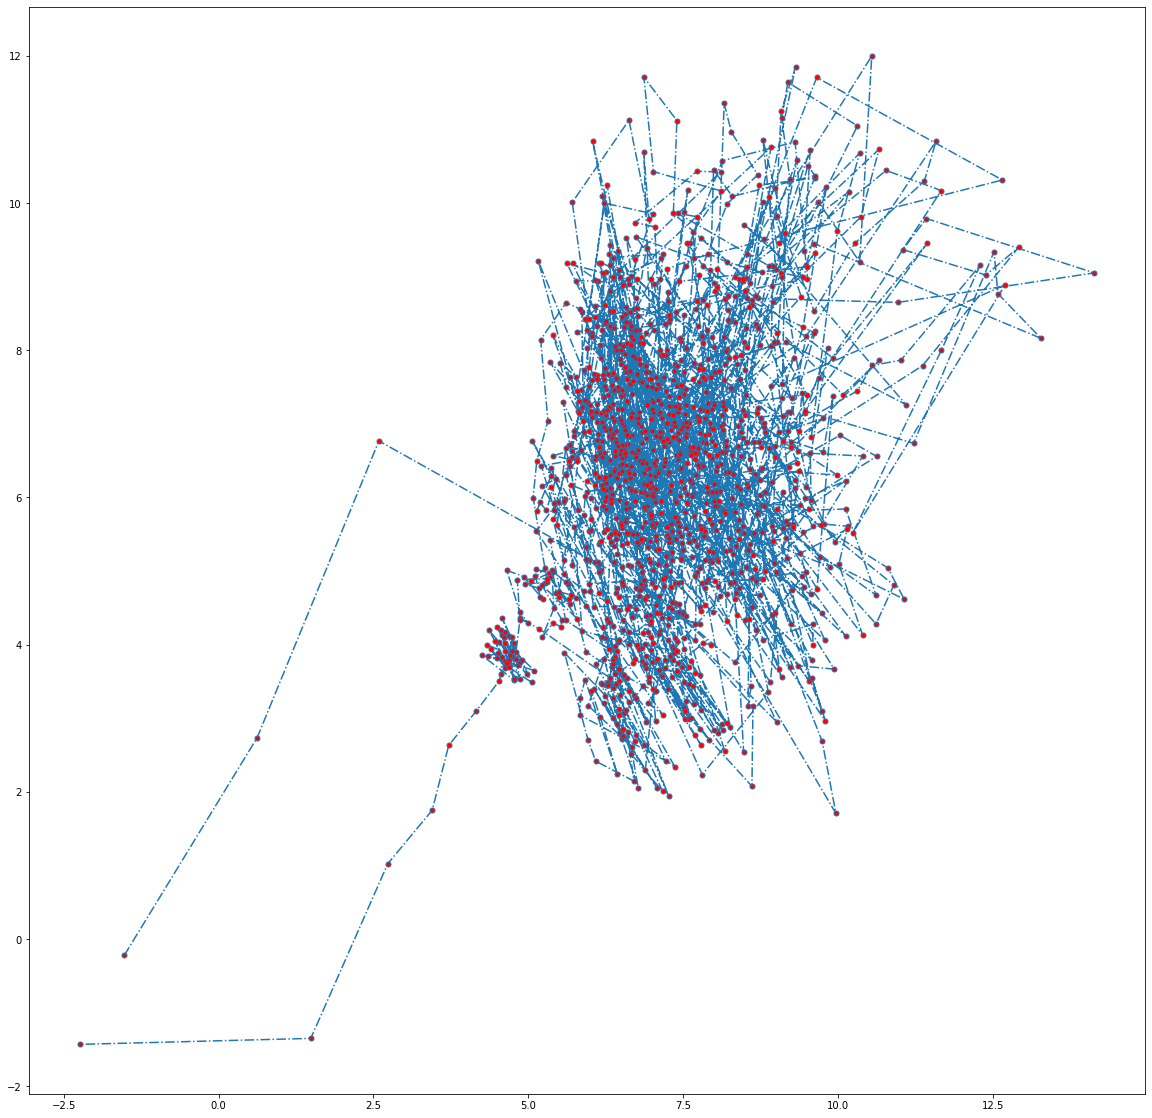

In [15]:
song_num = np.random.randint(0,num_of_ws_per_song.shape[0])
plt.figure(figsize=(20,20))
plt.plot(song_orders[song_num][:, 0], song_orders[song_num][:, 1], '-.o', markersize=5, markerfacecolor='red')
plt.show()

## Create a new Waveset
We can now sample a new point in the latent space and create the corresponding waveset by passing the coordinates to our decoder. 

In [16]:
def reconstruct(data):
    latent_representations = autoencoder.encoder.predict(data)
    reconstructed_ws = autoencoder.decoder.predict(latent_representations)
    reconstructed_ws = denormalise(reconstructed_ws, -100, 0)
    return reconstructed_ws

def denormalise(array, original_min, original_max):
    denorm_array = (array - array.min()) / (array.max() - array.min())
    denorm_array = denorm_array * (original_max - original_min) + original_min
    return denorm_array

Original Specto:



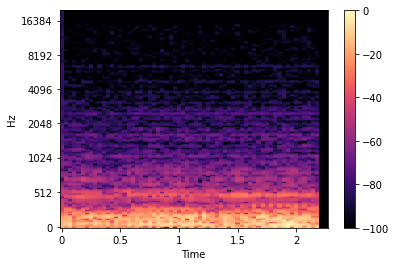

Reconstructed Specto:



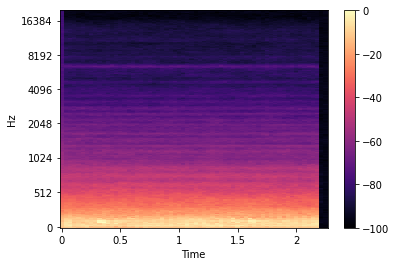

In [33]:

sr = 44100
WIN_LENGTH = int(sr/15)
HOP_LENGTH = int(sr/28)
N_FFT = int(sr/8)

def display_reconstructed_specto(index):

    reconstructed_ws = reconstruct(x_train[index:index+1])
    original_ws = denormalise(x_train[index], -100, 0)
    
    print("Original Specto:\n")
    librosa.display.specshow(
        original_ws.reshape(original_ws.shape[0],original_ws.shape[1]),
        x_axis='time',
        y_axis='mel',
        sr=44100,
        fmax=20000,
        hop_length=int(44100/28),
    )
    plt.colorbar()
    plt.show()
    

    print("Reconstructed Specto:\n")
    librosa.display.specshow(
        reconstructed_ws[0].reshape(reconstructed_ws[0].shape[0],reconstructed_ws[0].shape[1]),
        x_axis='time',
        y_axis='mel',
        sr=sr,
        fmax=20000,
        hop_length=HOP_LENGTH,
    )
    plt.colorbar()
    plt.show()
    
   

display_reconstructed_specto(np.random.randint(0,x_train.shape[0]))